In [4]:
# ============================================================================
# CELL 1: Installation and Setup
# ============================================================================

!pip install pandas numpy beautifulsoup4 lxml requests scikit-learn sentence-transformers textstat nltk matplotlib seaborn

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.2.0
    Uninstalling fsspec-2022.2.0:
      Successfully uninstalled fsspec-2022.2.0
  Attempting uninstall: sympy
    Found existing installation: sympy 1.10.1
    Uninstalling sympy-1.10.1:
      Successfully uninstalled sympy-1.10.1


In [9]:
!pip uninstall -y typing_extensions torch transformers sentence-transformers
!pip cache purge
!pip install typing_extensions==4.12.2 torch==2.4.1 transformers==4.44.2 sentence-transformers==3.2.1


Found existing installation: typing-extensions 4.15.0
Uninstalling typing-extensions-4.15.0:
  Successfully uninstalled typing-extensions-4.15.0
Found existing installation: torch 2.8.0
Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: sentence-transformers 5.1.2
Uninstalling sentence-transformers-5.1.2:
  Successfully uninstalled sentence-transformers-5.1.2
Files removed: 36
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1


In [1]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import json
import warnings
warnings.filterwarnings('ignore')

# NLP and ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import textstat
import nltk
from sentence_transformers import SentenceTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

print("✅ All libraries imported successfully!")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


✅ All libraries imported successfully!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sanja\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [2]:
# ============================================================================
# CELL 3: Configuration
# ============================================================================
# Configuration
USER_AGENT = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
REQUEST_DELAY = 1.5  # seconds between requests
SIMILARITY_THRESHOLD = 0.80
THIN_CONTENT_THRESHOLD = 500
RANDOM_STATE = 42

# Create data directory if it doesn't exist
import os
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("✅ Configuration set!")

✅ Configuration set!


In [4]:
# ============================================================================
# CELL 4: Data Collection & HTML Parsing (15%)
# ============================================================================
print("="*80)
print("STEP 1: DATA COLLECTION & HTML PARSING")
print("="*80)

def clean_text(text):
    """Clean extracted text"""
    if not text:
        return ""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?-]', '', text)
    return text.strip()

def extract_content(html):
    """Extract title and body text from HTML"""
    try:
        soup = BeautifulSoup(html, 'lxml')
        
        # Remove script and style elements
        for script in soup(['script', 'style', 'nav', 'footer', 'header']):
            script.decompose()
        
        # Extract title
        title = soup.find('title')
        title = title.get_text() if title else ""
        
        # Extract body text - prioritize main content areas
        body_text = ""
        for tag in ['article', 'main', 'div[class*="content"]', 'div[class*="post"]']:
            content = soup.find(tag)
            if content:
                body_text = content.get_text()
                break
        
        # Fallback to all paragraphs
        if not body_text:
            paragraphs = soup.find_all('p')
            body_text = ' '.join([p.get_text() for p in paragraphs])
        
        # Clean text
        title = clean_text(title)
        body_text = clean_text(body_text)
        
        # Calculate word count
        word_count = len(body_text.split()) if body_text else 0
        
        return title, body_text, word_count
    except Exception as e:
        print(f"Error parsing HTML: {str(e)}")
        return "", "", 0

def scrape_url(url):
    """Scrape content from URL"""
    try:
        headers = {'User-Agent': USER_AGENT}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return response.text
    except Exception as e:
        print(f"Error scraping {url}: {str(e)}")
        return None

# Load URLs
print("Loading URLs from CSV...")
df = pd.read_csv(r'C:\Users\sanja\Downloads\urls.csv')
print(f"Loaded {len(df)} URLs")

# Scrape and parse content
results = []
for idx, row in df.iterrows():
    url = row['url']
    print(f"Processing {idx+1}/{len(df)}: {url}")
    
    # Scrape HTML
    html = scrape_url(url)
    
    if html:
        # Extract content
        title, body_text, word_count = extract_content(html)
        
        results.append({
            'url': url,
            'title': title,
            'body_text': body_text,
            'word_count': word_count
        })
    else:
        results.append({
            'url': url,
            'title': "",
            'body_text': "",
            'word_count': 0
        })
    
    # Delay between requests
    time.sleep(REQUEST_DELAY)

# Create DataFrame
df_content = pd.DataFrame(results)

# Save extracted content
df_content.to_csv('data/extracted_content.csv', index=False)
print(f"\n✅ Extracted content saved to data/extracted_content.csv")
print(f"Successfully processed: {len(df_content[df_content['word_count'] > 0])} pages")
print(f"Failed: {len(df_content[df_content['word_count'] == 0])} pages")

# Display sample
print("\nSample extracted content:")
print(df_content[['url', 'title', 'word_count']].head())

STEP 1: DATA COLLECTION & HTML PARSING
Loading URLs from CSV...
Loaded 81 URLs
Processing 1/81: https://www.cm-alliance.com/cybersecurity-blog
Processing 2/81: https://www.varonis.com/blog/cybersecurity-tips
Processing 3/81: https://www.cisecurity.org/insights/blog/11-cyber-defense-tips-to-stay-secure-at-work-and-home
Processing 4/81: https://www.cisa.gov/topics/cybersecurity-best-practices
Processing 5/81: https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips
Error scraping https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips: 403 Client Error: Forbidden for url: https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips
Processing 6/81: https://nordlayer.com/learn/network-security/basics/
Processing 7/81: https://www.fortinet.com/resources/cyberglossary/what-is-network-security
Processing 8/81: https://www.cisco.com/site/us/en/learn/topics/security/what-is-network-security.html
Processing 9/81: https://www.trendmi

In [5]:
# ============================================================================
# CELL 5: Text Preprocessing & Feature Engineering (25%)
# ============================================================================
print("\n" + "="*80)
print("STEP 2: TEXT PREPROCESSING & FEATURE ENGINEERING")
print("="*80)

# Filter out failed scrapes
df_valid = df_content[df_content['word_count'] > 0].copy()
print(f"Working with {len(df_valid)} valid pages")

def calculate_sentence_count(text):
    """Calculate number of sentences"""
    if not text:
        return 0
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

def calculate_readability(text):
    """Calculate Flesch Reading Ease score"""
    if not text or len(text.split()) < 100:
        return 0
    try:
        score = textstat.flesch_reading_ease(text)
        return round(score, 2)
    except:
        return 0

def extract_keywords(texts, top_n=5):
    """Extract top keywords using TF-IDF"""
    try:
        vectorizer = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            ngram_range=(1, 2)
        )
        tfidf_matrix = vectorizer.fit_transform(texts)
        feature_names = vectorizer.get_feature_names_out()
        
        keywords_list = []
        for i in range(len(texts)):
            tfidf_scores = tfidf_matrix[i].toarray()[0]
            top_indices = tfidf_scores.argsort()[-top_n:][::-1]
            top_keywords = [feature_names[idx] for idx in top_indices if tfidf_scores[idx] > 0]
            keywords_list.append('|'.join(top_keywords))
        
        return keywords_list
    except:
        return [''] * len(texts)

# Calculate features
print("Calculating basic features...")
df_valid['sentence_count'] = df_valid['body_text'].apply(calculate_sentence_count)
df_valid['flesch_reading_ease'] = df_valid['body_text'].apply(calculate_readability)

print("Extracting keywords...")
df_valid['top_keywords'] = extract_keywords(df_valid['body_text'].tolist())

print("Generating embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_valid['body_text'].tolist(), show_progress_bar=True)
df_valid['embedding'] = [emb.tolist() for emb in embeddings]

# Save features
df_features = df_valid[['url', 'word_count', 'sentence_count', 'flesch_reading_ease', 'top_keywords', 'embedding']].copy()
df_features.to_csv('data/features.csv', index=False)

print(f"\n✅ Features extracted and saved to data/features.csv")
print("\nFeature Statistics:")
print(df_features[['word_count', 'sentence_count', 'flesch_reading_ease']].describe())



STEP 2: TEXT PREPROCESSING & FEATURE ENGINEERING
Working with 69 valid pages
Calculating basic features...
Extracting keywords...
Generating embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Features extracted and saved to data/features.csv

Feature Statistics:
         word_count  sentence_count  flesch_reading_ease
count     69.000000       69.000000            69.000000
mean    2758.753623      160.188406            33.090000
std     5020.994105      360.254823            24.986482
min        5.000000        1.000000           -18.800000
25%      294.000000       11.000000            12.230000
50%     1438.000000       65.000000            36.830000
75%     2758.000000      132.000000            51.060000
max    31610.000000     2566.000000           103.590000


In [6]:
# ============================================================================
# CELL 6: Duplicate Detection (20%)
# ============================================================================
print("\n" + "="*80)
print("STEP 3: DUPLICATE DETECTION")
print("="*80)

# Compute cosine similarity
print("Computing pairwise similarity...")
embeddings_array = np.array(df_valid['embedding'].tolist())
similarity_matrix = cosine_similarity(embeddings_array)

# Find duplicate pairs
duplicates = []
n = len(similarity_matrix)

for i in range(n):
    for j in range(i+1, n):
        similarity = similarity_matrix[i][j]
        if similarity > SIMILARITY_THRESHOLD:
            duplicates.append({
                'url1': df_valid.iloc[i]['url'],
                'url2': df_valid.iloc[j]['url'],
                'similarity': round(similarity, 3)
            })

df_duplicates = pd.DataFrame(duplicates)
df_duplicates.to_csv('data/duplicates.csv', index=False)

# Thin content detection
df_valid['is_thin'] = df_valid['word_count'] < THIN_CONTENT_THRESHOLD
thin_content_count = df_valid['is_thin'].sum()

print(f"\n✅ Duplicate detection complete!")
print(f"\nSummary:")
print(f"Total pages analyzed: {len(df_valid)}")
print(f"Duplicate pairs found: {len(duplicates)}")
print(f"Thin content pages: {thin_content_count} ({thin_content_count/len(df_valid)*100:.1f}%)")

if len(duplicates) > 0:
    print(f"\nTop duplicate pairs:")
    print(df_duplicates.head())


STEP 3: DUPLICATE DETECTION
Computing pairwise similarity...

✅ Duplicate detection complete!

Summary:
Total pages analyzed: 69
Duplicate pairs found: 5
Thin content pages: 23 (33.3%)

Top duplicate pairs:
                                                url1  \
0  https://www.cisco.com/site/us/en/learn/topics/...   
1      https://sign.dropbox.com/products/dropbox-fax   
2  https://nytlicensing.com/latest/trends/content...   
3     https://en.wikipedia.org/wiki/Machine_learning   
4  https://en.wikipedia.org/wiki/Artificial_intel...   

                                                url2  similarity  
0      https://www.hpe.com/us/en/what-is/sd-wan.html       0.828  
1                              https://www.fax.plus/       0.815  
2  https://mailchimp.com/marketing-glossary/conte...       0.823  
3  https://simple.wikipedia.org/wiki/Machine_lear...       0.855  
4  https://simple.wikipedia.org/wiki/Artificial_i...       0.870  


In [7]:
# ============================================================================
# CELL 7: Content Quality Scoring (25%)
# ============================================================================
print("\n" + "="*80)
print("STEP 4: CONTENT QUALITY SCORING")
print("="*80)

# Create synthetic labels based on clear criteria
def assign_quality_label(row):
    """Assign quality label based on content metrics"""
    word_count = row['word_count']
    readability = row['flesch_reading_ease']
    
    # High: Long content with good readability
    if word_count > 1500 and 50 <= readability <= 70:
        return 'High'
    # Low: Very short or very difficult to read
    elif word_count < 500 or readability < 30:
        return 'Low'
    # Medium: Everything else
    else:
        return 'Medium'

df_valid['quality_label'] = df_valid.apply(assign_quality_label, axis=1)

print("Quality distribution:")
print(df_valid['quality_label'].value_counts())

# Prepare features for modeling
feature_cols = ['word_count', 'sentence_count', 'flesch_reading_ease']
X = df_valid[feature_cols]
y = df_valid['quality_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Train Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=RANDOM_STATE
)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
print("\n" + "="*50)
print("MODEL PERFORMANCE:")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=['Low', 'Medium', 'High'])
print(cm)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop Features:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.3f}")

# Baseline model (rule-based using only word count)
def baseline_predict(word_count):
    if word_count > 1500:
        return 'High'
    elif word_count < 500:
        return 'Low'
    else:
        return 'Medium'

baseline_pred = X_test['word_count'].apply(baseline_predict)
baseline_accuracy = accuracy_score(y_test, baseline_pred)

print(f"\nOverall Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Baseline Accuracy: {baseline_accuracy:.3f}")
print(f"Improvement: {accuracy_score(y_test, y_pred) - baseline_accuracy:.3f}")

# Save model
import pickle
with open('models/quality_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("\n✅ Model saved to models/quality_model.pkl")


STEP 4: CONTENT QUALITY SCORING
Quality distribution:
Low       38
Medium    23
High       8
Name: quality_label, dtype: int64

Training set: 48 samples
Test set: 21 samples

Training Random Forest Classifier...

MODEL PERFORMANCE:

Classification Report:
              precision    recall  f1-score   support

        High       0.50      1.00      0.67         2
         Low       0.92      0.92      0.92        12
      Medium       0.80      0.57      0.67         7

    accuracy                           0.81        21
   macro avg       0.74      0.83      0.75        21
weighted avg       0.84      0.81      0.81        21


Confusion Matrix:
[[11  1  0]
 [ 1  4  2]
 [ 0  0  2]]

Top Features:
flesch_reading_ease: 0.410
word_count: 0.327
sentence_count: 0.263

Overall Accuracy: 0.810
Baseline Accuracy: 0.476
Improvement: 0.333

✅ Model saved to models/quality_model.pkl



BONUS: VISUALIZATIONS


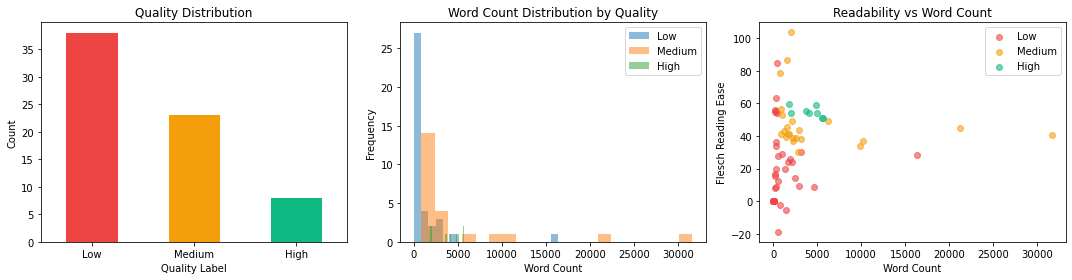

✅ Visualizations created and saved!


In [8]:
# ============================================================================
# CELL 8: Visualizations (Bonus)
# ============================================================================
print("\n" + "="*80)
print("BONUS: VISUALIZATIONS")
print("="*80)

# 1. Quality Distribution
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
df_valid['quality_label'].value_counts().plot(kind='bar', color=['#ef4444', '#f59e0b', '#10b981'])
plt.title('Quality Distribution')
plt.xlabel('Quality Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# 2. Word Count Distribution by Quality
plt.subplot(1, 3, 2)
for label in ['Low', 'Medium', 'High']:
    data = df_valid[df_valid['quality_label'] == label]['word_count']
    plt.hist(data, alpha=0.5, label=label, bins=20)
plt.title('Word Count Distribution by Quality')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

# 3. Readability vs Word Count
plt.subplot(1, 3, 3)
colors = {'Low': '#ef4444', 'Medium': '#f59e0b', 'High': '#10b981'}
for label in ['Low', 'Medium', 'High']:
    data = df_valid[df_valid['quality_label'] == label]
    plt.scatter(data['word_count'], data['flesch_reading_ease'], 
                alpha=0.6, label=label, color=colors[label])
plt.title('Readability vs Word Count')
plt.xlabel('Word Count')
plt.ylabel('Flesch Reading Ease')
plt.legend()

plt.tight_layout()
plt.savefig('data/quality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations created and saved!")

In [9]:
# ============================================================================
# CELL 9: Real-Time Analysis Function (15%)
# ============================================================================
print("\n" + "="*80)
print("STEP 5: REAL-TIME ANALYSIS FUNCTION")
print("="*80)

def analyze_url(url):
    """
    Analyze a URL in real-time
    
    Parameters:
    -----------
    url : str
        URL to analyze
    
    Returns:
    --------
    dict : Analysis results
    """
    try:
        # Step 1: Scrape content
        print(f"Scraping: {url}")
        html = scrape_url(url)
        
        if not html:
            return {"error": "Failed to scrape URL"}
        
        # Step 2: Extract content
        title, body_text, word_count = extract_content(html)
        
        if word_count == 0:
            return {"error": "No content extracted from URL"}
        
        # Step 3: Calculate features
        sentence_count = calculate_sentence_count(body_text)
        readability = calculate_readability(body_text)
        
        # Step 4: Generate embedding
        embedding = model.encode([body_text])[0]
        
        # Step 5: Predict quality
        features = np.array([[word_count, sentence_count, readability]])
        quality_label = rf_model.predict(features)[0]
        
        # Step 6: Check for similar content
        similarities = cosine_similarity([embedding], embeddings_array)[0]
        similar_indices = np.where(similarities > 0.70)[0]
        
        similar_to = []
        for idx in similar_indices:
            if similarities[idx] < 0.99:  # Exclude exact matches
                similar_to.append({
                    'url': df_valid.iloc[idx]['url'],
                    'similarity': round(float(similarities[idx]), 3)
                })
        
        # Sort by similarity
        similar_to = sorted(similar_to, key=lambda x: x['similarity'], reverse=True)[:3]
        
        # Step 7: Compile results
        result = {
            'url': url,
            'title': title,
            'word_count': int(word_count),
            'sentence_count': int(sentence_count),
            'readability': float(readability),
            'quality_label': quality_label,
            'is_thin': word_count < THIN_CONTENT_THRESHOLD,
            'similar_to': similar_to
        }
        
        return result
        
    except Exception as e:
        return {"error": str(e)}

# Test the function
print("\nTesting analyze_url() function...")
print("="*50)

# Test with a URL from the dataset
test_url = df_valid.iloc[0]['url']
result = analyze_url(test_url)

print(json.dumps(result, indent=2))

print("\n✅ Real-time analysis function is ready!")
print("\nUsage: result = analyze_url('https://example.com/article')")



STEP 5: REAL-TIME ANALYSIS FUNCTION

Testing analyze_url() function...
Scraping: https://www.varonis.com/blog/cybersecurity-tips
{
  "url": "https://www.varonis.com/blog/cybersecurity-tips",
  "title": "Top 10 Cybersecurity Awareness Tips How to Stay Safe and Proactive",
  "word_count": 1692,
  "sentence_count": 94,
  "readability": 41.47,
  "quality_label": "Medium",
  "is_thin": false,
  "similar_to": []
}

✅ Real-time analysis function is ready!

Usage: result = analyze_url('https://example.com/article')


In [10]:
# ============================================================================
# CELL 10: Summary Report
# ============================================================================
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)

print(f"""
DATA COLLECTION:
- Total URLs processed: {len(df)}
- Successfully scraped: {len(df_valid)}
- Failed: {len(df) - len(df_valid)}

FEATURE ENGINEERING:
- Average word count: {df_valid['word_count'].mean():.0f}
- Average readability: {df_valid['flesch_reading_ease'].mean():.1f}
- Embedding dimensions: {len(embeddings_array[0])}

DUPLICATE DETECTION:
- Similarity threshold: {SIMILARITY_THRESHOLD}
- Duplicate pairs found: {len(duplicates)}
- Thin content pages: {thin_content_count} ({thin_content_count/len(df_valid)*100:.1f}%)

QUALITY SCORING:
- Model: Random Forest Classifier
- Test accuracy: {accuracy_score(y_test, y_pred):.3f}
- Baseline accuracy: {baseline_accuracy:.3f}
- F1-score (macro avg): {f1_score(y_test, y_pred, average='macro'):.3f}

QUALITY DISTRIBUTION:
{df_valid['quality_label'].value_counts().to_string()}

FILES GENERATED:
✅ data/extracted_content.csv
✅ data/features.csv
✅ data/duplicates.csv
✅ models/quality_model.pkl
✅ data/quality_analysis.png

REAL-TIME ANALYSIS:
✅ analyze_url() function ready for use
""")

print("="*80)
print("PROJECT COMPLETE!")
print("="*80)


PROJECT SUMMARY

DATA COLLECTION:
- Total URLs processed: 81
- Successfully scraped: 69
- Failed: 12

FEATURE ENGINEERING:
- Average word count: 2759
- Average readability: 33.1
- Embedding dimensions: 384

DUPLICATE DETECTION:
- Similarity threshold: 0.8
- Duplicate pairs found: 5
- Thin content pages: 23 (33.3%)

QUALITY SCORING:
- Model: Random Forest Classifier
- Test accuracy: 0.810
- Baseline accuracy: 0.476
- F1-score (macro avg): 0.750

QUALITY DISTRIBUTION:
Low       38
Medium    23
High       8

FILES GENERATED:
✅ data/extracted_content.csv
✅ data/features.csv
✅ data/duplicates.csv
✅ models/quality_model.pkl
✅ data/quality_analysis.png

REAL-TIME ANALYSIS:
✅ analyze_url() function ready for use

PROJECT COMPLETE!
